<a href="https://colab.research.google.com/github/dimitrii-ustinov/fraud-analysis/blob/main/Fraud_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Data Analysis Project


There are multiple datasets in fraud detection domain.

Here are a few examples:

https://www.kaggle.com/competitions/ieee-fraud-detection/overview

https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/data

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

It is of my personal interest to discover datasets that have less exposure and, thus, have no identified solution to the fraud classification task.

For the purpose of this ML fraud detection analysis we are going to use this dataset:

https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset


This notebook contains the following chapters:
1. EDA and Data Cleaning
2. Variable Engineering
3. ML Training and Testing

In [141]:
#Installations
!pip install category_encoders
!pip install catboost

In [165]:
# Necessary libraries and dependancies
#Scikit-learn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


#Other
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from google.colab import drive
from category_encoders import HashingEncoder
from collections import Counter

import warnings
warnings.filterwarnings("ignore", message=".*Parameters: { \"use_label_encoder\" } are not used.*")

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Definition of functions

In [143]:
# Train the model
def model_performance(pipeline, param_distributions, verbose=0, n_iter=50, scoring = "recall", cv = 5, random_state = 11):
  grid_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, verbose=verbose, n_iter=n_iter, scoring = scoring, cv = cv, random_state = random_state)
  grid_search.fit(X_train, y_train)
  return (grid_search.best_estimator_, grid_search.best_score_)

In [144]:
#Create confusion matrix
def get_conf_matrix(best_estimator, X_test, y_test):
  y_pred = best_estimator.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)
  return conf_matrix

In [145]:
# Confusion Matrix visualization
def plot_confusion_matrix(best_estimator, X_test, y_test, figsize = (4,3)):
  conf_matrix = get_conf_matrix(best_estimator, X_test, y_test)
  plt.figure(figsize=figsize)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_estimator.classes_, yticklabels=best_estimator.classes_)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix Heatmap')
  plt.show()

In [146]:
# Print test dataset performance
def print_test_performance(estimator, X_test, y_test):
  test_accuracy = estimator.score(X_test, y_test)
  print(f"Test set accuracy: {test_accuracy:.4f}, for the model {estimator}")

In [147]:
#Print recall results for the test dataset
def print_test_recall(best_estimator, X_test, y_test):
  conf_matrix = get_conf_matrix(best_estimator, X_test, y_test)
  # True Positives (TP) and False Negatives (FN)
  TP = conf_matrix[1, 1]
  FN = conf_matrix[1, 0]

  # Calculate recall
  recall = TP / (TP + FN)

  print(f"Test recall: {recall:.4f}")

### Data Loading

In [148]:
#Change the source if you are running outside of Google Colab
data  = pd.read_csv('/content/drive/My Drive/Fraud_Detection/credit_card_transactions.csv')

In [149]:
# # Separate the classes
# fraud_data = data[data['is_fraud'] == 1]
# non_fraud_data = data[data['is_fraud'] == 0]

# # Resample each class
# fraud_resampled = resample(fraud_data, replace=True, n_samples=1000, random_state=2024)
# non_fraud_resampled = resample(non_fraud_data, replace=False, n_samples=9000, random_state=2024)

# # Combine and shuffle
# stratified_sample = pd.concat([fraud_resampled, non_fraud_resampled]).sample(frac=1, random_state=2024)

# # Verify proportions
# print(stratified_sample['is_fraud'].value_counts())


In [150]:
# For development purposes cut the datasets to 10000 entries each
data_short = data.sample(n=10000, replace=False, random_state=2025)

# 1. EDA and Data Cleaning

In [151]:
#Change the pd view:
pd.set_option('display.max_columns', None)

In [152]:
data_short.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
210166,210166,2019-04-17 11:13:20,3535808924394848,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,55.84,Matthew,Myers,M,4936 Michelle Points,Tower Hill,IL,62571,39.3900,-88.9597,1532,Radio broadcast assistant,1980-01-09,901fe3b7cd03de9ab5067c9148913736,1334661200,40.137831,-88.093561,0,61873.0
44348,44348,2019-01-27 13:14:20,4044436772018844508,"fraud_Koss, McLaughlin and Mayer",food_dining,28.65,Amy,Abbott,F,01505 Amy Stravenue,Dayton,OH,45415,39.8355,-84.2613,479994,Environmental manager,1970-11-09,bfb7efd0a6c26967cd51a3fc2b4bf5ad,1327670060,39.824050,-84.859119,0,47374.0
111385,111385,2019-03-04 13:15:29,4514242065619750,fraud_Lemke and Sons,travel,6.51,Janet,Carpenter,F,9870 Collins Flat,Laramie,WY,82072,41.4247,-105.4781,35371,"Pilot, airline",1988-09-02,ef8cd088e9be83cc1bfe1a6696cb8500,1330866929,40.714536,-105.344827,0,NaN
309762,309762,2019-05-30 07:06:08,4586260469584,fraud_Stoltenberg-Beatty,shopping_pos,59.78,Melody,Thompson,F,0362 Anderson Wall,Mound City,MO,64470,40.1362,-95.2138,1631,Architect,1953-01-20,35582118dad4809139c8c60b0e68ffaf,1338361568,40.239586,-94.549957,0,64489.0
458649,458649,2019-07-21 22:11:00,371226440126102,fraud_Denesik and Sons,shopping_pos,9.84,Stacy,Lambert,F,85430 Julie Trafficway Suite 792,Mulberry Grove,IL,62262,38.9311,-89.2463,1810,Race relations officer,1974-12-24,9fb7b4eb38aeb04755e7b12068ebcdd0,1342908660,38.552903,-88.955188,0,62881.0


As seen from the datasets, the target column is "isFraud" in transaction file. Also, we can join the datasets by the TransactionID, but as stated in the documentation, some transactions in identity table may not have a corresponding transactionID in transaction table.

In [153]:
# Shape
print(data_short.shape)

(10000, 24)


In [154]:
#Count the number of Fraudulent and non-fraudulent transactions
print(data_short['is_fraud'].value_counts())

is_fraud
0    9934
1      66
Name: count, dtype: int64


In [155]:
#High-level information

data_short = data_short.rename(columns={"Unnamed: 0": "id"})

data_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 210166 to 1212305
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10000 non-null  int64  
 1   trans_date_trans_time  10000 non-null  object 
 2   cc_num                 10000 non-null  int64  
 3   merchant               10000 non-null  object 
 4   category               10000 non-null  object 
 5   amt                    10000 non-null  float64
 6   first                  10000 non-null  object 
 7   last                   10000 non-null  object 
 8   gender                 10000 non-null  object 
 9   street                 10000 non-null  object 
 10  city                   10000 non-null  object 
 11  state                  10000 non-null  object 
 12  zip                    10000 non-null  int64  
 13  lat                    10000 non-null  float64
 14  long                   10000 non-null  float64
 15  

In [156]:
#High-level statistics
data_short.describe()

,id,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,8459.000000
mean,6.425302e+05,4.120016e+17,71.987219,49050.409500,38.563758,-90.370581,8.381854e+04,1.349047e+09,38.570601,-90.372659,0.006600,47064.515427
std,3.710408e+05,1.299643e+18,136.784260,26928.841648,5.094440,13.834023,2.878280e+05,1.271563e+07,5.125165,13.838663,0.080976,25873.025460
min,3.870000e+02,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325394e+09,19.178930,-166.420229,0.000000,1002.000000
25%,3.208090e+05,1.800482e+14,9.747500,27249.000000,34.690200,-96.985800,7.250000e+02,1.338674e+09,34.800396,-97.049422,0.000000,25121.000000
50%,6.349090e+05,3.519607e+15,48.140000,48214.000000,39.390000,-87.692300,2.395000e+03,1.348762e+09,39.382836,-87.584319,0.000000,46304.000000
75%,9.617032e+05,4.634956e+15,83.580000,72042.000000,42.015800,-80.307000,1.968500e+04,1.358868e+09,41.996515,-80.336168,0.000000,68431.000000
max,1.296475e+06,4.992346e+18,4522.110000,99783.000000,65.689900,-67.950300,2.906700e+06,1.371811e+09,66.218150,-67.156453,1.000000,99403.000000


#### Missing values

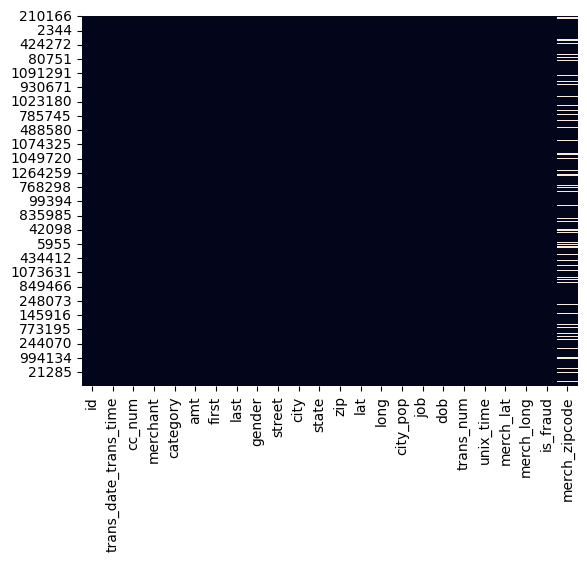

In [157]:
sns.heatmap(data_short.isnull(), cbar=False)
plt.show()

As seen from the graph, only zipcodes are missing. We may impute them later from lat and long

#### Outliers

Building boxplots for each set can help us estimate if any of our variables have outliers.

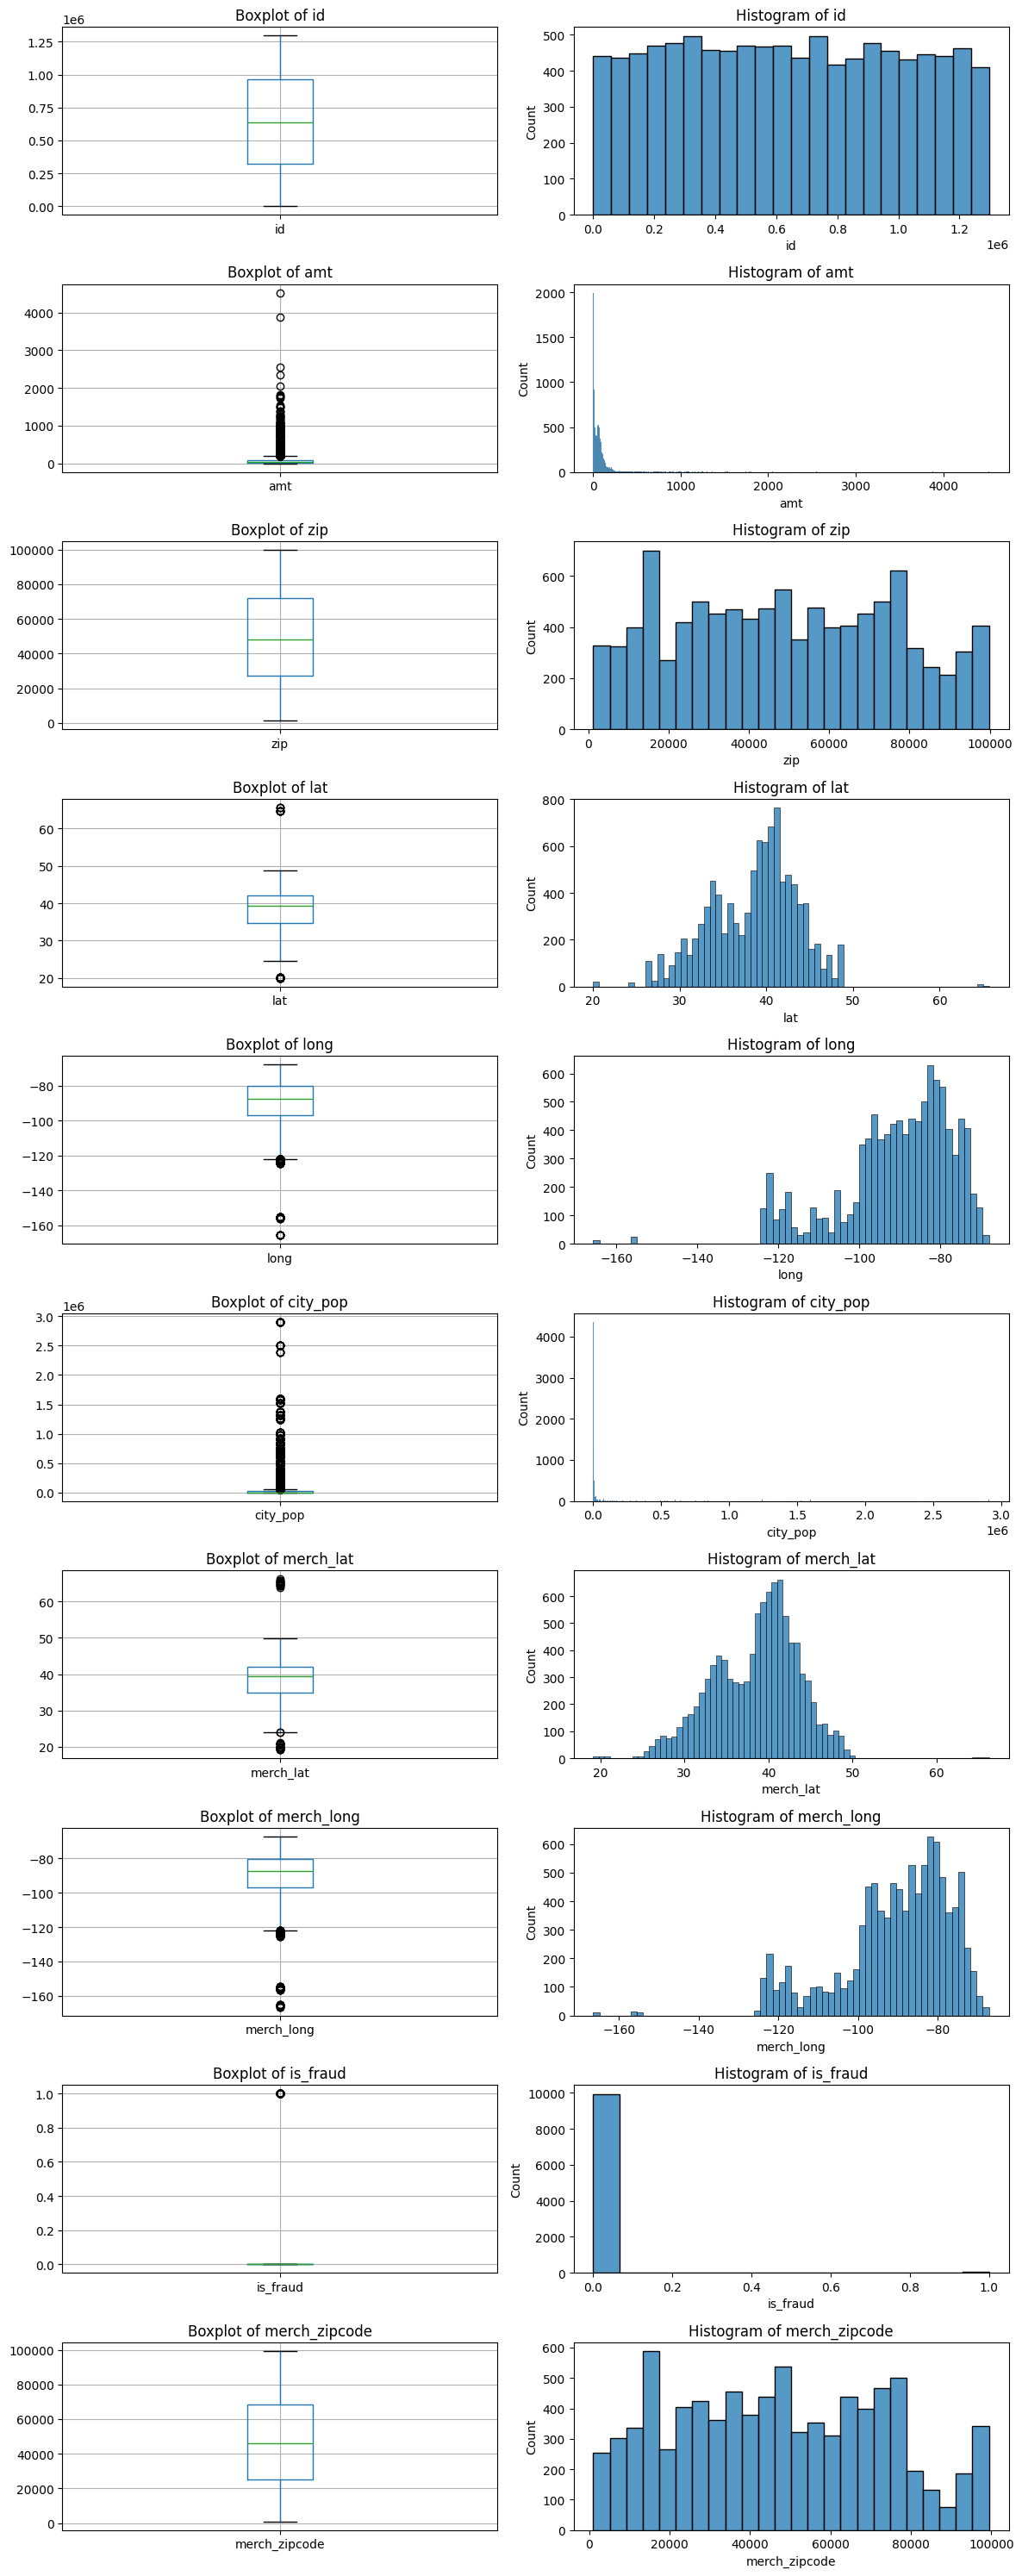

In [158]:
#Building boxplots

cls_to_plot = [col for col in data_short.columns if col not in ["cc_num", "unix_time",] and pd.api.types.is_numeric_dtype(data_short[col])]
# data_short.boxplot(column = cls_to_plot, rot=90)
# plt.show()

num_col = 2

num_rows = len(cls_to_plot)

fig, axes = plt.subplots(num_rows, num_col, figsize=(12,3*num_rows))
axes = axes.flatten()

for i, column in enumerate(cls_to_plot):
  #Boxplots
  data_short.boxplot(column = [column], ax = axes[i * 2])
  axes[i * 2].set_title(f"Boxplot of {column}")
  #Histograms
  sns.histplot(data_short[column], ax=axes[i * 2 + 1])
  axes[i * 2 + 1].set_title(f"Histogram of {column}")

plt.tight_layout()
plt.show()


There are clearly some outliers in lat and long as well as amount and city population. . After visual examination of the outlier in the
table there was no evidence of error in the data.

In [159]:
data_short.head(2)

,id,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
210166,210166,2019-04-17 11:13:20,3535808924394848,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,55.84,Matthew,Myers,M,4936 Michelle Points,Tower Hill,IL,62571,39.3900,-88.9597,1532,Radio broadcast assistant,1980-01-09,901fe3b7cd03de9ab5067c9148913736,1334661200,40.137831,-88.093561,0,61873.0
44348,44348,2019-01-27 13:14:20,4044436772018844508,"fraud_Koss, McLaughlin and Mayer",food_dining,28.65,Amy,Abbott,F,01505 Amy Stravenue,Dayton,OH,45415,39.8355,-84.2613,479994,Environmental manager,1970-11-09,bfb7efd0a6c26967cd51a3fc2b4bf5ad,1327670060,39.824050,-84.859119,0,47374.0


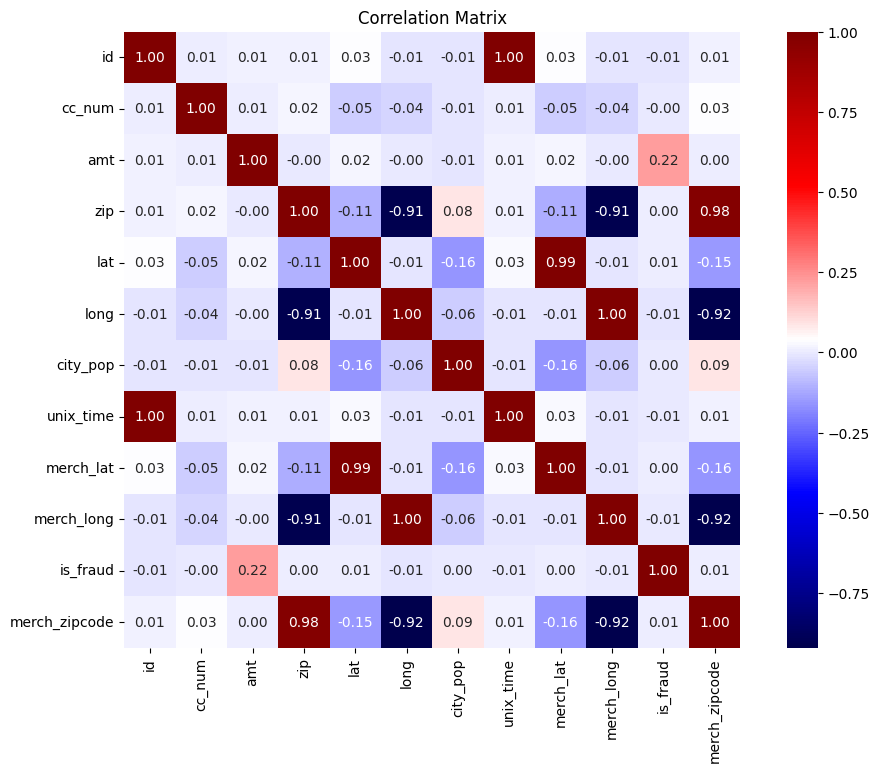

In [160]:
# Calculate the correlation matrix
key = [ 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'trans_date_trans_time']
data_corr = data_short.drop(columns=key)
correlation_matrix = data_corr.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,             # Annotate cells with the correlation value
    fmt=".2f",              # Format numbers with two decimal places
    cmap="seismic",         # Colormap
    cbar=True,              # Show color bar
    square=True             # Ensure the heatmap cells are square
)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix reveals some insights about the data. Specifically, it is observed that the ID is perfectly correlated with unix_time making this column obsolete for the analysis. Additionally, merch_zipcode, long and merch_long have high negative correlation emphasizing that as the merch zipcode of a seller grows, the merch_long and long falls. Moreover, lat is highly correlated with merch_lat making one of the columns obsolete. We can use one of the feature selection algorithms to choose the most significant features. Finally, it is observed that the amount has medium positive correlation with our target, fraud, making it one of possible predictors for a model.

Next we need to construct new variables from categorical variables using various encoding techniques. For this analysis we implement one-hot encoding for low-cardinality var and hashing for high cardinality var.


# 2. Variable Engineering

In [161]:
# Extract features
data_short['trans_date_trans_time'] = pd.to_datetime(data_short['trans_date_trans_time'])
data_short['Year'] = data_short['trans_date_trans_time'].dt.year.astype(int)
data_short['Month'] = data_short['trans_date_trans_time'].dt.month.astype(int)
data_short['Day'] = data_short['trans_date_trans_time'].dt.day
data_short['Hour'] = data_short['trans_date_trans_time'].dt.hour
data_short['Day_of_week'] = data_short['trans_date_trans_time'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data_short['Unix'] = data_short['trans_date_trans_time'].astype('int64') // 10**9
data_short.drop(columns=['trans_date_trans_time'], inplace=True)
data_short.head(3)

,id,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,Year,Month,Day,Hour,Day_of_week,Unix
210166,210166,3535808924394848,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,55.84,Matthew,Myers,M,4936 Michelle Points,Tower Hill,IL,62571,39.3900,-88.9597,1532,Radio broadcast assistant,1980-01-09,901fe3b7cd03de9ab5067c9148913736,1334661200,40.137831,-88.093561,0,61873.0,2019,4,17,11,2,1555499600
44348,44348,4044436772018844508,"fraud_Koss, McLaughlin and Mayer",food_dining,28.65,Amy,Abbott,F,01505 Amy Stravenue,Dayton,OH,45415,39.8355,-84.2613,479994,Environmental manager,1970-11-09,bfb7efd0a6c26967cd51a3fc2b4bf5ad,1327670060,39.824050,-84.859119,0,47374.0,2019,1,27,13,6,1548594860
111385,111385,4514242065619750,fraud_Lemke and Sons,travel,6.51,Janet,Carpenter,F,9870 Collins Flat,Laramie,WY,82072,41.4247,-105.4781,35371,"Pilot, airline",1988-09-02,ef8cd088e9be83cc1bfe1a6696cb8500,1330866929,40.714536,-105.344827,0,NaN,2019,3,4,13,0,1551705329


#### EncodingsTransformations

In [162]:
#Let's see the missing values first:
data_short.isnull().sum()

,0
id,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


Only one column has missing values. We can create a shadow variable to capture the missing values from merh_zipcode and use lat long to impute the zipcodes

In [163]:
#Create a shadow var of missing values
data_short["merch_zip_missing"] = data_short["merch_zipcode"].isnull().astype(int)
data_short.head(3)

,id,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,Year,Month,Day,Hour,Day_of_week,Unix,merch_zip_missing
210166,210166,3535808924394848,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,55.84,Matthew,Myers,M,4936 Michelle Points,Tower Hill,IL,62571,39.3900,-88.9597,1532,Radio broadcast assistant,1980-01-09,901fe3b7cd03de9ab5067c9148913736,1334661200,40.137831,-88.093561,0,61873.0,2019,4,17,11,2,1555499600,0
44348,44348,4044436772018844508,"fraud_Koss, McLaughlin and Mayer",food_dining,28.65,Amy,Abbott,F,01505 Amy Stravenue,Dayton,OH,45415,39.8355,-84.2613,479994,Environmental manager,1970-11-09,bfb7efd0a6c26967cd51a3fc2b4bf5ad,1327670060,39.824050,-84.859119,0,47374.0,2019,1,27,13,6,1548594860,0
111385,111385,4514242065619750,fraud_Lemke and Sons,travel,6.51,Janet,Carpenter,F,9870 Collins Flat,Laramie,WY,82072,41.4247,-105.4781,35371,"Pilot, airline",1988-09-02,ef8cd088e9be83cc1bfe1a6696cb8500,1330866929,40.714536,-105.344827,0,NaN,2019,3,4,13,0,1551705329,1


Computation of the merch_zipcode using geolocator is too slow to process entire dataframe, so we have to use a less robust but faster method. We will use KNN with 3 neighbours to determine the zipcode for the merch_zipcode column

In [164]:
# Prepare data with known ZIP codes
known_locations = data_short[data_short['merch_zip_missing'] == 0][['lat', 'long', 'merch_zipcode']]

# Fit a nearest neighbors model
nbrs = NearestNeighbors(n_neighbors=3).fit(known_locations[['lat', 'long']])

# Find nearest neighbors for missing ZIP codes
missing_locations = data_short[data_short['merch_zip_missing'] == 1][['lat', 'long']]
distances, indices = nbrs.kneighbors(missing_locations)

# Assign nearest neighbor ZIP codes to missing rows
data_short.loc[data_short['merch_zip_missing'] == 1, 'merch_zipcode'] = \
    np.array(known_locations.iloc[indices[:, 0]]['merch_zipcode'])

Next, we want to check if we have low cardinality non-numeric columns that we can one-hot encode into numric representation.(Optionally we can use embeddings to transform high-cardinality texts into numeric features.)

In [118]:
#Check number of unique values in each column

cardinality_all_columns = data_short.nunique()
print(cardinality_all_columns)

id                   10000
cc_num                 910
merchant               693
category                14
amt                   6701
first                  338
last                   465
gender                   2
street                 910
city                   838
state                   50
zip                    899
lat                    897
long                   898
city_pop               823
job                    476
dob                    897
trans_num            10000
unix_time             9999
merch_lat             9996
merch_long            9998
is_fraud                 2
merch_zipcode         6759
Year                     2
Month                   12
Day                     31
Hour                    24
Day_of_week              7
Unix                  9999
merch_zip_missing        1
dtype: int64


Looking at the unique values in each column we can estimate that category, gender and state can be one-hot encoded.
Other textual featres can be hashed or converted to embeddings.

In [119]:
data_short.head(3)

,id,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,Year,Month,Day,Hour,Day_of_week,Unix,merch_zip_missing
210166,210166,3535808924394848,"fraud_Rutherford, Homenick and Bergstrom",grocery_net,55.84,Matthew,Myers,M,4936 Michelle Points,Tower Hill,IL,62571,39.3900,-88.9597,1532,Radio broadcast assistant,1980-01-09,901fe3b7cd03de9ab5067c9148913736,1334661200,40.137831,-88.093561,0,61873.0,2019,4,17,11,2,1555499600,0
44348,44348,4044436772018844508,"fraud_Koss, McLaughlin and Mayer",food_dining,28.65,Amy,Abbott,F,01505 Amy Stravenue,Dayton,OH,45415,39.8355,-84.2613,479994,Environmental manager,1970-11-09,bfb7efd0a6c26967cd51a3fc2b4bf5ad,1327670060,39.824050,-84.859119,0,47374.0,2019,1,27,13,6,1548594860,0
111385,111385,4514242065619750,fraud_Lemke and Sons,travel,6.51,Janet,Carpenter,F,9870 Collins Flat,Laramie,WY,82072,41.4247,-105.4781,35371,"Pilot, airline",1988-09-02,ef8cd088e9be83cc1bfe1a6696cb8500,1330866929,40.714536,-105.344827,0,82072.0,2019,3,4,13,0,1551705329,0


#### One-hot encoding

In [120]:
#Create one-hot encoded categorical columns
data_encoded = pd.get_dummies(data_short, columns=['category', 'gender', 'state'], drop_first=True)

data_encoded.head(3)

,id,cc_num,merchant,amt,first,last,street,city,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,Year,Month,Day,Hour,Day_of_week,Unix,merch_zip_missing,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
210166,210166,3535808924394848,"fraud_Rutherford, Homenick and Bergstrom",55.84,Matthew,Myers,4936 Michelle Points,Tower Hill,62571,39.3900,-88.9597,1532,Radio broadcast assistant,1980-01-09,901fe3b7cd03de9ab5067c9148913736,1334661200,40.137831,-88.093561,0,61873.0,2019,4,17,11,2,1555499600,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
44348,44348,4044436772018844508,"fraud_Koss, McLaughlin and Mayer",28.65,Amy,Abbott,01505 Amy Stravenue,Dayton,45415,39.8355,-84.2613,479994,Environmental manager,1970-11-09,bfb7efd0a6c26967cd51a3fc2b4bf5ad,1327670060,39.824050,-84.859119,0,47374.0,2019,1,27,13,6,1548594860,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
111385,111385,4514242065619750,fraud_Lemke and Sons,6.51,Janet,Carpenter,9870 Collins Flat,Laramie,82072,41.4247,-105.4781,35371,"Pilot, airline",1988-09-02,ef8cd088e9be83cc1bfe1a6696cb8500,1330866929,40.714536,-105.344827,0,82072.0,2019,3,4,13,0,1551705329,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


#### Encoding high-cardinality features

Next, we can hash columns where cardinality is more than 50 to include them into classification. Specifcally, columns = [ merchant, first, last, street, city, job, dob, trans_num].

For this analysis (due to limited computational resources) we can use hash with minimal number of features for the hash function such as sqrt(nunique_values)

In [121]:
# Compare number of components from taking a sqrt and 2^log2 of number of transactions
n_comp = int(2**(np.log2(data_short['trans_num'].nunique())-5))
print(n_comp)
print(np.sqrt(data_short['trans_num'].nunique()))
print(data_short['trans_num'].nunique())

312
100.0
10000


In [122]:
# We will use square root as it will requre less resources
hashed_data = data_encoded.copy()

for key, val in cardinality_all_columns.items():
  if val > 60 and key in [ 'merchant', 'first', 'last', 'street', 'city', 'job', 'dob', 'trans_num']:
    print(f'{key} - {val}')

    # HashingEncoder for each column
    #n_comp = int(2**(np.log2(data_short[val].nunique())-5))
    encoder_col = HashingEncoder(n_components= int(np.sqrt(val)))  # square root of unique values in the categorical col (use 2**n in the real world scenario)

    # Apply encoding
    hashed_col = encoder_col.fit_transform(data_short[key])

     # Rename hashed column names to incorporate {key}_*
    hashed_col.columns = [f"{key}_{i}" for i in range(1, hashed_col.shape[1] + 1)]

    # Combined result
    hashed_data = pd.concat([hashed_data, hashed_col], axis=1)

    #Drop the categorical column
    hashed_data.drop(columns=[key], inplace=True)

hashed_data.head(3)


merchant - 693
first - 338
last - 465
street - 910
city - 838
job - 476
dob - 897
trans_num - 10000


,id,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,Year,Month,Day,Hour,Day_of_week,Unix,merch_zip_missing,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,merchant_1,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9,merchant_10,merchant_11,merchant_12,merchant_13,merchant_14,merchant_15,merchant_16,merchant_17,merchant_18,merchant_19,merchant_20,merchant_21,merchant_22,merchant_23,merchant_24,merchant_25,merchant_26,first_1,first_2,first_3,first_4,first_5,first_6,first_7,first_8,first_9,first_10,first_11,first_12,first_13,first_14,first_15,first_16,first_17,first_18,last_1,last_2,last_3,last_4,last_5,last_6,last_7,last_8,last_9,last_10,last_11,last_12,last_13,last_14,last_15,last_16,last_17,last_18,last_19,last_20,last_21,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10,street_11,street_12,street_13,street_14,street_15,street_16,street_17,street_18,street_19,street_20,street_21,street_22,street_23,street_24,street_25,street_26,street_27,street_28,street_29,street_30,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,city_23,city_24,city_25,city_26,city_27,city_28,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11,job_12,job_13,job_14,job_15,job_16,job_17,job_18,job_19,job_20,job_21,dob_1,dob_2,dob_3,dob_4,dob_5,dob_6,dob_7,dob_8,dob_9,dob_10,dob_11,dob_12,dob_13,dob_14,dob_15,dob_16,dob_17,dob_18,dob_19,dob_20,dob_21,dob_22,dob_23,dob_24,dob_25,dob_26,dob_27,dob_28,dob_29,trans_num_1,trans_num_2,trans_num_3,trans_num_4,trans_num_5,trans_num_6,trans_num_7,trans_num_8,trans_num_9,trans_num_10,trans_num_11,trans_num_12,trans_num_13,trans_num_14,trans_num_15,trans_num_16,trans_num_17,trans_num_18,trans_num_19,trans_num_20,trans_num_21,trans_num_22,trans_num_23,trans_num_24,trans_num_25,trans_num_26,trans_num_27,trans_num_28,trans_num_29,trans_num_30,trans_num_31,trans_num_32,trans_num_33,trans_num_34,trans_num_35,trans_num_36,trans_num_37,trans_num_38,trans_num_39,trans_num_40,trans_num_41,trans_num_42,trans_num_43,trans_num_44,trans_num_45,trans_num_46,trans_num_47,trans_num_48,trans_num_49,trans_num_50,trans_num_51,trans_num_52,trans_num_53,trans_num_54,trans_num_55,trans_num_56,trans_num_57,trans_num_58,trans_num_59,trans_num_60,trans_num_61,trans_num_62,trans_num_63,trans_num_64,trans_num_65,trans_num_66,trans_num_67,trans_num_68,trans_num_69,trans_num_70,trans_num_71,trans_num_72,trans_num_73,trans_num_74,trans_num_75,trans_num_76,trans_num_77,trans_num_78,trans_num_79,trans_num_80,trans_num_81,trans_num_82,trans_num_83,trans_num_84,trans_num_85,trans_num_86,trans_num_87,trans_num_88,trans_num_89,trans_num_90,trans_num_91,trans_num_92,trans_num_93,trans_num_94,trans_num_95,trans_num_96,trans_num_97,trans_num_98,trans_num_99,trans_num_100
210166,210166,3535808924394848,55.84,62571,39.3900,-88.9597,1532,1334661200,40.137831,-88.093561,0,61873.0,2019,4,17,11,2,1555499600,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [123]:
print(f"Now the dataframe has {hashed_data.shape[1]} columns")

Now the dataframe has 355 columns


In [124]:
hashed_data.describe()

,id,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode,Year,Month,Day,Hour,Day_of_week,Unix,merch_zip_missing,merchant_1,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9,merchant_10,merchant_11,merchant_12,merchant_13,merchant_14,merchant_15,merchant_16,merchant_17,merchant_18,merchant_19,merchant_20,merchant_21,merchant_22,merchant_23,merchant_24,merchant_25,merchant_26,first_1,first_2,first_3,first_4,first_5,first_6,first_7,first_8,first_9,first_10,first_11,first_12,first_13,first_14,first_15,first_16,first_17,first_18,last_1,last_2,last_3,last_4,last_5,last_6,last_7,last_8,last_9,last_10,last_11,last_12,last_13,last_14,last_15,last_16,last_17,last_18,last_19,last_20,last_21,street_1,street_2,street_3,street_4,street_5,street_6,street_7,street_8,street_9,street_10,street_11,street_12,street_13,street_14,street_15,street_16,street_17,street_18,street_19,street_20,street_21,street_22,street_23,street_24,street_25,street_26,street_27,street_28,street_29,street_30,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,city_23,city_24,city_25,city_26,city_27,city_28,job_1,job_2,job_3,job_4,job_5,job_6,job_7,job_8,job_9,job_10,job_11,job_12,job_13,job_14,job_15,job_16,job_17,job_18,job_19,job_20,job_21,dob_1,dob_2,dob_3,dob_4,dob_5,dob_6,dob_7,dob_8,dob_9,dob_10,dob_11,dob_12,dob_13,dob_14,dob_15,dob_16,dob_17,dob_18,dob_19,dob_20,dob_21,dob_22,dob_23,dob_24,dob_25,dob_26,dob_27,dob_28,dob_29,trans_num_1,trans_num_2,trans_num_3,trans_num_4,trans_num_5,trans_num_6,trans_num_7,trans_num_8,trans_num_9,trans_num_10,trans_num_11,trans_num_12,trans_num_13,trans_num_14,trans_num_15,trans_num_16,trans_num_17,trans_num_18,trans_num_19,trans_num_20,trans_num_21,trans_num_22,trans_num_23,trans_num_24,trans_num_25,trans_num_26,trans_num_27,trans_num_28,trans_num_29,trans_num_30,trans_num_31,trans_num_32,trans_num_33,trans_num_34,trans_num_35,trans_num_36,trans_num_37,trans_num_38,trans_num_39,trans_num_40,trans_num_41,trans_num_42,trans_num_43,trans_num_44,trans_num_45,trans_num_46,trans_num_47,trans_num_48,trans_num_49,trans_num_50,trans_num_51,trans_num_52,trans_num_53,trans_num_54,trans_num_55,trans_num_56,trans_num_57,trans_num_58,trans_num_59,trans_num_60,trans_num_61,trans_num_62,trans_num_63,trans_num_64,trans_num_65,trans_num_66,trans_num_67,trans_num_68,trans_num_69,trans_num_70,trans_num_71,trans_num_72,trans_num_73,trans_num_74,trans_num_75,trans_num_76,trans_num_77,trans_num_78,trans_num_79,trans_num_80,trans_num_81,trans_num_82,trans_num_83,trans_num_84,trans_num_85,trans_num_86,trans_num_87,trans_num_88,trans_num_89,trans_num_90,trans_num_91,trans_num_92,trans_num_93,trans_num_94,trans_num_95,trans_num_96,trans_num_97,trans_num_98,trans_num_99,trans_num_100
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.0,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00

In [125]:
#Check the df value count
print(hashed_data["is_fraud"].value_counts())

is_fraud
0    9934
1      66
Name: count, dtype: int64


Finally, we split the dataset into training and testing.

In [126]:
# Specify features (X) and target variable (y)
X = hashed_data.drop('is_fraud', axis=1)  # Features
y = hashed_data['is_fraud']  # Target variable

# Create train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2025)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (7000, 354) (7000,)
Test set shape: (3000, 354) (3000,)


# 3. ML Training and Testing

#### 1) Logistic Regression

In [ ]:
# Pipeline operations
scaler = StandardScaler()
pca = PCA()
random_oversampler = RandomOverSampler(sampling_strategy=0.2)
lr = LogisticRegression()

# Create a pipeline from imblearn package
pipeline = Pipeline([("scaler", scaler), ("random_oversampler", random_oversampler), ("pca", pca), ('lr', lr)])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('random_oversampler', RandomOverSampler(sampling_strategy=0.2)),
  ('pca', PCA()),
  ('lr', LogisticRegression())],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'random_oversampler': RandomOverSampler(sampling_strategy=0.2),
 'pca': PCA(),
 'lr': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'random_oversampler__random_state': None,
 'random_oversampler__sampling_strategy': 0.2,
 'random_oversampler__shrinkage': None,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 

In [ ]:
# Check the class distribution before and after oversampling
print("Original class distribution:", Counter(y_train))
oversampler = pipeline.named_steps['random_oversampler']
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
print("Class distribution after oversampling:", Counter(y_resampled))

Original class distribution: Counter({0: 6954, 1: 46})
Class distribution after oversampling: Counter({0: 6954, 1: 1390})


In [ ]:
# Cross-validation and grid search of optimal parameters for the model

param_grid = {
    'scaler': [StandardScaler()],
    'random_oversampler__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'pca__n_components' : range(5, 20),
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear'],
}

best_estimator, best_score = model_performance(pipeline, param_grid)
print(f"Recall score {best_score:.4f}")
print(f"Best parameters: {best_estimator}")

Recall score 0.6467
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('random_oversampler', RandomOverSampler(sampling_strategy=1)),
                ('pca', PCA(n_components=5)),
                ('lr', LogisticRegression(C=1, solver='liblinear'))])


In [ ]:
#Assess model accuracy and best model parameters
print_test_performance(best_estimator, X_test, y_test)

Test set accuracy: 0.8697, for the model Pipeline(steps=[('scaler', StandardScaler()),
                ('random_oversampler', RandomOverSampler(sampling_strategy=1)),
                ('pca', PCA(n_components=5)),
                ('lr', LogisticRegression(C=1, solver='liblinear'))])


Since we are interested in the Recall here, we can use confusion matrix to see the performance of the model

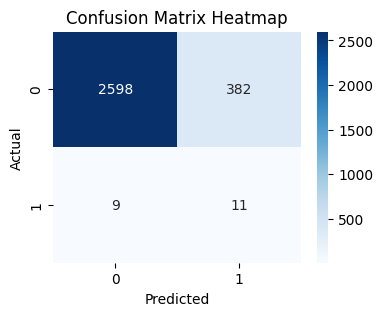

In [ ]:
#Create a confusion matrix
plot_confusion_matrix(best_estimator, X_test, y_test)

In [ ]:
# True Positives (TP) and False Negatives (FN)
print_test_recall(best_estimator, X_test, y_test)

Test recall: 0.5500


Basic model with Logistic regression has recall of ~0.55. Let's see if we can improve this recall by applying more sophisticated resampling and classification techniques.

#### 2) Logistic Regression with SMOTE

In [ ]:
#Change resampling and paramgrid
# Pipeline operations
smote = SMOTE()

# Create a pipeline from imblearn package
pipeline = Pipeline([("scaler", scaler), ("smote", smote), ("pca", pca), ('lr', lr)])#  ("svm", svm)])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('smote', SMOTE()),
  ('pca', PCA()),
  ('lr', LogisticRegression())],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'smote': SMOTE(),
 'pca': PCA(),
 'lr': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'smote__k_neighbors': 5,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'deprecated',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 

In [ ]:
#Set the parameters for the grid
param_grid = {
    'scaler': [StandardScaler()],
    'smote__sampling_strategy' : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'smote__k_neighbors' : range(3, 11),
    'pca__n_components' : range(5, 20),
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l2'],
    'lr__solver': ['liblinear'],
}
#RandomizedSearch to speed up the tuning process
best_estimator, best_score = model_performance(pipeline, param_grid)
print(f"Recall score {best_score:.4f}")
print(f"Best parameters: {best_estimator}")

Recall score 0.5800
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=4, sampling_strategy=1)),
                ('pca', PCA(n_components=5)),
                ('lr', LogisticRegression(C=10, solver='liblinear'))])


In [ ]:
#Assess model accuracy and best model parameters
print_test_performance(best_estimator, X_test, y_test)

Test set accuracy: 0.8870, for the model Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=4, sampling_strategy=1)),
                ('pca', PCA(n_components=5)),
                ('lr', LogisticRegression(C=10, solver='liblinear'))])


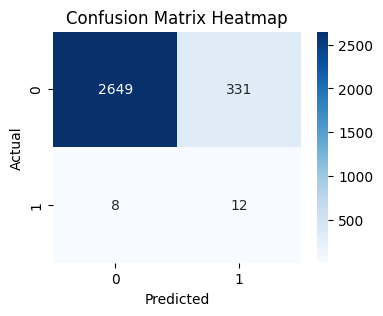

In [ ]:
#Create a confusion matrix
plot_confusion_matrix(best_estimator, X_test, y_test)

In [ ]:
# Print test recall
print_test_recall(best_estimator, X_test, y_test)

Test recall: 0.6000


 SMOTE as a different oversampling technique showed simiar recall. Now we can try using more sophisticated ML algorithms

#### 3) Random Forest

In [ ]:
#Change resampling and paramgrid
# Pipeline operations
scaler = StandardScaler()
pca = PCA()
smote = SMOTE(sampling_strategy=0.2)
rf = RandomForestClassifier()

# Create a pipeline from imblearn package
pipeline = Pipeline([("scaler", scaler), ("smote", smote), ("pca", pca), ("rf", rf)])#  ("svm", svm)])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('smote', SMOTE(sampling_strategy=0.2)),
  ('pca', PCA()),
  ('rf', RandomForestClassifier())],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'smote': SMOTE(sampling_strategy=0.2),
 'pca': PCA(),
 'rf': RandomForestClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'smote__k_neighbors': 5,
 'smote__random_state': None,
 'smote__sampling_strategy': 0.2,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf'

In [ ]:
#Set the parameters for the grid
param_grid = {
    'scaler': [StandardScaler()],
    'smote__sampling_strategy' : [0.2, 0.5, 0.75],
    'smote__k_neighbors' : range(3, 11, 2),
    'pca__n_components' : range(5, 20, 5),
    'rf__n_estimators': range(50, 201, 50),  # Number of trees in Random Forest
    'rf__max_depth': range(10, 51, 10),
    'rf__min_samples_split': range(2, 11, 2),
    'rf__min_samples_leaf': range(1, 5),
    'rf__bootstrap': [True, False]
}
#RandomizedSearch to speed up the tuning process
best_estimator, best_score = model_performance(pipeline, param_grid)
print(f"Recall score {best_score:.4f}")
print(f"Best parameters: {best_estimator}")

Recall score 0.2822
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=7, sampling_strategy=0.5)),
                ('pca', PCA(n_components=5)),
                ('rf',
                 RandomForestClassifier(max_depth=40, min_samples_leaf=4,
                                        min_samples_split=8,
                                        n_estimators=150))])


In [ ]:
#Assess model accuracy and best model parameters
print_test_performance(best_estimator, X_test, y_test)

Test set accuracy: 0.9733, for the model Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=7, sampling_strategy=0.5)),
                ('pca', PCA(n_components=5)),
                ('rf',
                 RandomForestClassifier(max_depth=40, min_samples_leaf=4,
                                        min_samples_split=8,
                                        n_estimators=150))])


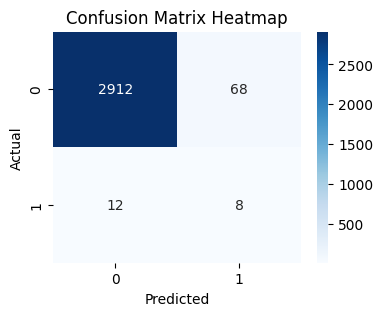

In [ ]:
#Create a confusion matrix
plot_confusion_matrix(best_estimator, X_test, y_test)

In [ ]:
# Print test recall
print_test_recall(best_estimator, X_test, y_test)

Test recall: 0.4000


#### 4) XG Boost

In [166]:
#Change resampling and paramgrid
# Pipeline operations
scaler = StandardScaler()
pca = PCA()
smote = SMOTE()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create a pipeline from imblearn package
pipeline = Pipeline([("scaler", scaler), ("smote", smote), ("pca", pca), ("xgb", xgb)])#  ("svm", svm)])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('smote', SMOTE()),
  ('pca', PCA()),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric='logloss',
                 feature_types=None, gamma=None, grow_policy=None,
                 importance_type=None, interaction_constraints=None,
                 learning_rate=None, max_bin=None, max_cat_threshold=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, multi_strategy=None, n_estimators=None,
                 n_jobs=None, num_parallel_tree=None, random_state=None, ...))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'smote': SMOTE(),


In [167]:
param_grid = {
    'scaler': [StandardScaler()],
    'smote__sampling_strategy' : [0.2, 0.5, 0.75],
    'smote__k_neighbors' : range(3, 11),
    'pca__n_components' : range(5, 20),
    "xgb__n_estimators": [50, 100, 200],  # Number of boosting rounds (trees)
    "xgb__max_depth": [3, 5, 7],  # Maximum tree depth
    "xgb__learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "xgb__subsample": [0.6, 0.8, 1.0],  # Fraction of samples used for training
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features used per tree
    "xgb__gamma": [0, 1, 5],  # Minimum loss reduction for split
    "xgb__reg_alpha": [0, 0.1, 1],  # L1 regularization term
    "xgb__reg_lambda": [1, 2, 10, 100],  # L2 regularization term
}
#RandomizedSearch to speed up the tuning process
best_estimator, best_score = model_performance(pipeline, param_grid)
print(f"Recall score {best_score:.4f}")
print(f"Best parameters: {best_estimator}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:22:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:22:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:22:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Recall score 0.2622
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=4, sampling_strategy=0.5)),
                ('pca', PCA(n_components=5)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_..., grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
             

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:22:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [168]:
#Assess model accuracy and best model parameters
print_test_performance(best_estimator, X_test, y_test)

Test set accuracy: 0.9580, for the model Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=4, sampling_strategy=0.5)),
                ('pca', PCA(n_components=5)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_..., grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
         

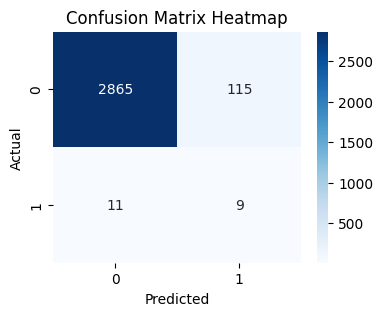

In [169]:
#Create a confusion matrix
plot_confusion_matrix(best_estimator, X_test, y_test)

In [170]:
# Print test recall
print_test_recall(best_estimator, X_test, y_test)

Test recall: 0.4500


#### 5) CatBoost

In [ ]:
#Change resampling and paramgrid
# Pipeline operations
scaler = StandardScaler()
pca = PCA()
#random_oversampler = RandomOverSampler()
smote = SMOTE()
catboost = CatBoostClassifier(verbose=0)

# Create a pipeline from imblearn package
pipeline = Pipeline([("scaler", scaler), ("smote", smote), ("pca", pca), ("catboost", catboost)])#  ("svm", svm)])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('smote', SMOTE()),
  ('pca', PCA()),
  ('catboost', <catboost.core.CatBoostClassifier at 0x7d714e613fd0>)],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'smote': SMOTE(),
 'pca': PCA(),
 'catboost': <catboost.core.CatBoostClassifier at 0x7d714e613fd0>,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'smote__k_neighbors': 5,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'catboost__verbose': 0}

In [ ]:
#Set the parameters for the grid
param_grid = {
    'scaler': [StandardScaler()],
    'smote__sampling_strategy' : [0.2, 0.5, 0.75],
    'smote__k_neighbors' : range(3, 11),
    'pca__n_components' : range(5, 20),
    "catboost__iterations": [100, 200, 300],  # Number of boosting rounds
    "catboost__depth": [4, 6, 8],  # Depth of trees
    "catboost__learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "catboost__l2_leaf_reg": [1, 3, 5],  # L2 regularization term
    "catboost__border_count": [32, 64, 128],  # Number of splits for numerical features
    "catboost__bagging_temperature": [0.0, 1.0, 2.0],  # Random strength for bagging
    "catboost__subsample": [0.6, 0.8, 1.0],  # Fraction of samples used for training
}
#RandomizedSearch to speed up the tuning process
best_estimator, best_score = model_performance(pipeline, param_grid)
print(f"Recall score {best_score:.4f}")
print(f"Best parameters: {best_estimator}")

Recall score 0.3200
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=4, sampling_strategy=0.5)),
                ('pca', PCA(n_components=10)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7d714e403ac0>)])


In [ ]:
#Assess model accuracy and best model parameters
print_test_performance(best_estimator, X_test, y_test)

Test set accuracy: 0.9533, for the model Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=4, sampling_strategy=0.5)),
                ('pca', PCA(n_components=10)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x7d714e403ac0>)])


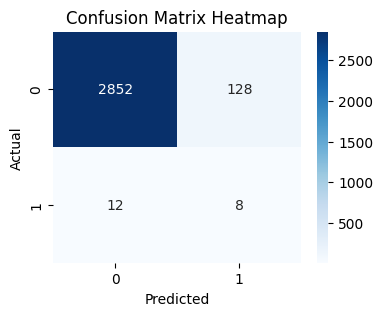

In [ ]:
#Create a confusion matrix
plot_confusion_matrix(best_estimator, X_test, y_test)

In [ ]:
# Print test recall
print_test_recall(best_estimator, X_test, y_test)

Test recall: 0.4000


#### 6) MLPClassifier

In [127]:
#Change resampling and paramgrid
# Pipeline operations
scaler = StandardScaler()
pca = PCA()
smote = SMOTE()
mlp = MLPClassifier(max_iter=500, random_state=11)

# Create a pipeline from imblearn package
pipeline = Pipeline([("scaler", scaler), ("smote", smote), ("pca", pca), ("mlp", mlp)])
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('smote', SMOTE()),
  ('pca', PCA()),
  ('mlp', MLPClassifier(max_iter=500, random_state=11))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'smote': SMOTE(),
 'pca': PCA(),
 'mlp': MLPClassifier(max_iter=500, random_state=11),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'smote__k_neighbors': 5,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'mlp__activation': 'relu',
 'mlp__alpha': 0.0001,
 'mlp__batch_size': 'auto',
 'mlp__beta_1': 0.9,
 'mlp__beta_2': 0.999,
 'mlp__early_stopping': False,
 'mlp__epsilon': 1e-08,
 'mlp__hidden_layer_sizes': (100,),
 'mlp__learning_rate': 'constant',
 'mlp__learnin

In [136]:
#Set the parameters for the grid
param_grid = {
    'scaler': [StandardScaler()],
    'smote__sampling_strategy' : [0.2, 0.5, 0.75],
    'smote__k_neighbors' : range(3, 11, 2),
    'pca__n_components' : range(5, 20, 5),
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],  # Number of neurons in hidden layers
    "mlp__activation": ['relu', 'tanh', 'logistic'],  # Activation functions
    "mlp__solver": ['adam', 'sgd'],  # Optimizers
    "mlp__alpha": [0.0001, 0.001, 0.01],  # L2 regularization term
    "mlp__learning_rate": ['constant', 'adaptive'],  # Learning rate schedule
    "mlp__learning_rate_init": [0.001, 0.01, 0.1],  # Initial learning rate
    "mlp__max_iter": [200, 500],  # Number of iterations
}
#RandomizedSearch to speed up the tuning process
best_estimator, best_score = model_performance(pipeline, param_grid)
print(f"Recall score {best_score:.4f}")
print(f"Best parameters: {best_estimator}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Recall score 0.4911
Best parameters: Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=3, sampling_strategy=0.75)),
                ('pca', PCA(n_components=5)),
                ('mlp',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(100, 50), random_state=11,
                               solver='sgd'))])


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [137]:
#Assess model accuracy and best model parameters
print_test_performance(best_estimator, X_test, y_test)

Test set accuracy: 0.9427, for the model Pipeline(steps=[('scaler', StandardScaler()),
                ('smote', SMOTE(k_neighbors=3, sampling_strategy=0.75)),
                ('pca', PCA(n_components=5)),
                ('mlp',
                 MLPClassifier(activation='logistic',
                               hidden_layer_sizes=(100, 50), random_state=11,
                               solver='sgd'))])


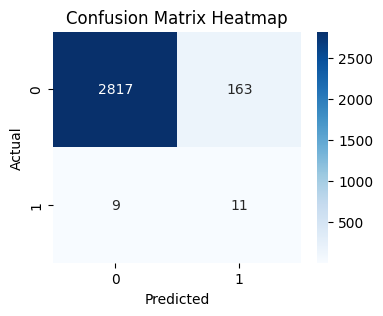

In [138]:
#Create a confusion matrix
plot_confusion_matrix(best_estimator, X_test, y_test)

In [139]:
# Print test recall
print_test_recall(best_estimator, X_test, y_test)

Test recall: 0.5500


In [140]:
print(best_estimator[3])

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),
              random_state=11, solver='sgd')


# Conclusion

After trying 6 different set ups for this subset we identified that __Logistic Regression__ is the best one with a recall of __~0.6__. At the same time __Logistic Regression__ has significant FP rate resulting in higher operational costs to assess those transactions. As an alternative, __XG Boost__ or __MPL__ can be considered as they demonstrated comparative __Recall__ with significantly higher precision (lower FP).

 This research may benefit from further analysis. It is recommended to use embeddings as an alternative to hashing as it might preserve more information from the features. Additionally, this analysis does not incorporate the cost of bank procedures associated with the time required to check all those transactions that are FP. In the long term it is important to develop the metrics that are associated with business outcomes and incorporate the optimal balance between fraud loses (FN) and operational costs (FP).